# Time Series Forecast with Python 

## Objective:

Based on how often the words'mental health' have been google worldwide in the past 5 years, how often will it likely be googled in the future?

# 1: Import the libraries

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime, timedelta
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

from statsmodels.tsa.stattools import kpss, adfuller

import warnings 
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (10, 4)

# 2: Source the data

In [42]:
df = pd.read_csv('multiTimeline.csv')

In [43]:
df.head()

,Category: All categories
Week,mental health: (Worldwide)
2016-07-17,29
2016-07-24,31
2016-07-31,31
2016-08-07,31


In [44]:
# the header is incorrect here - we need to skip a row 

In [45]:
df = pd.read_csv('multiTimeline.csv', skiprows = 1)
df.head()

,Week,mental health: (Worldwide)
0,2016-07-17,29
1,2016-07-24,31
2,2016-07-31,31
3,2016-08-07,31
4,2016-08-14,30


In [46]:
# just checking that there are 261 rows and 2 columns 

df.info

<bound method DataFrame.info of            Week  mental health: (Worldwide)
0    2016-07-17                          29
1    2016-07-24                          31
2    2016-07-31                          31
3    2016-08-07                          31
4    2016-08-14                          30
..          ...                         ...
256  2021-06-13                          50
257  2021-06-20                          49
258  2021-06-27                          50
259  2021-07-04                          45
260  2021-07-11                          57

[261 rows x 2 columns]>

In [47]:
df.dtypes

Week                          object
mental health: (Worldwide)     int64
dtype: object

In [48]:
df['Week'] = pd.to_datetime(df['Week'])

In [49]:
df.set_index('Week', inplace = True)

In [50]:
df.index

DatetimeIndex(['2016-07-17', '2016-07-24', '2016-07-31', '2016-08-07',
               '2016-08-14', '2016-08-21', '2016-08-28', '2016-09-04',
               '2016-09-11', '2016-09-18',
               ...
               '2021-05-09', '2021-05-16', '2021-05-23', '2021-05-30',
               '2021-06-06', '2021-06-13', '2021-06-20', '2021-06-27',
               '2021-07-04', '2021-07-11'],
              dtype='datetime64[ns]', name='Week', length=261, freq=None)

In [51]:
df['12-2019']

,mental health: (Worldwide)
Week,
2019-12-01,51
2019-12-08,47
2019-12-15,42
2019-12-22,28
2019-12-29,36


In [52]:
mh_ts = df['mental health: (Worldwide)']

In [53]:
mh_ts.head()

Week
2016-07-17    29
2016-07-24    31
2016-07-31    31
2016-08-07    31
2016-08-14    30
Name: mental health: (Worldwide), dtype: int64

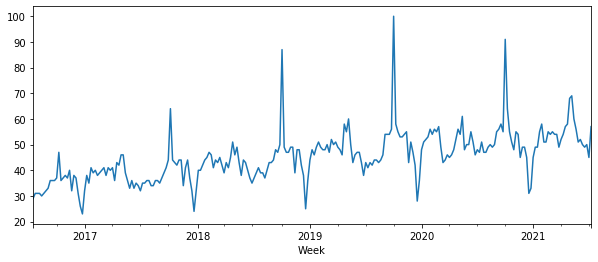

In [54]:
mh_ts.plot()

# 3. Data Analysis to find ARIMA (p,d,q) - parameters

## 3.1 Decomposition

In [55]:
decomposition = seasonal_decompose(mh_ts, model = 'multiplicative')

# Decomposing is just breaking out the time series into, trend, seasonality and its residuals 

# the model can be multiplicative or additive 

# in a multiplicative time series, the components multiply together to make the time series 
# if you have an increasing trend, the amplitude of seasonal activity increases 

# in an additive time series, the components add together to make the time series.

# you can specify the frequency of seasonality after model =, would put freq = 52 - in this case 
# as our seasonal period is a year - but our data is recorded in weeks 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

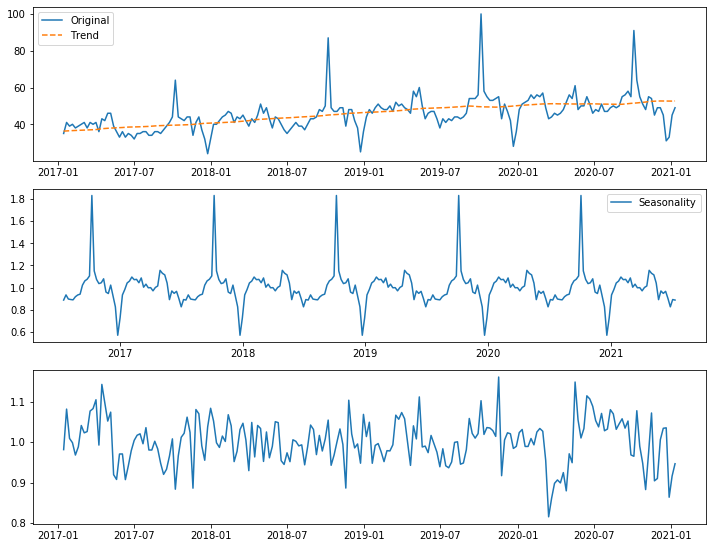

In [56]:
plt.figure(figsize = (10,10))

plt.figure(1)
plt.subplot(411)
plt.plot(trend*seasonal*residual, label = 'Original')
plt.plot(trend, label = 'Trend', linestyle = '--')
plt.legend(loc = 'best')

plt.subplot(412)
plt.plot(seasonal, label = 'Seasonality')
plt.legend(loc = 'best')

plt.subplot(413)
plt.plot(residual, label = 'Residuals')
plt.tight_layout()

# residuals are the oscilations around the average

## 3.2 (Partial) & Autocorrelation Function

we want to find the p- and the q- parameters from the ACF(autocorrelation function) and PACF(patial autocorrleation function)

ARIMA

AR(p)

auto-regressive - I am predicting based on previous values 

I (integrated)(d) - how many times to differenciate - we go through this later

MA(q)

moving average

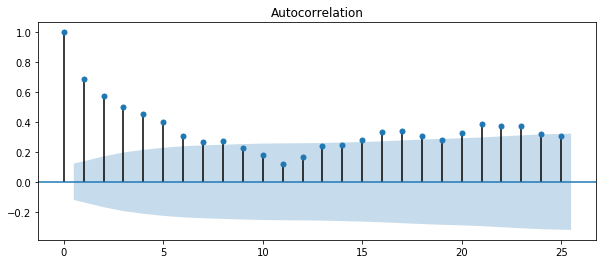

In [57]:
plot_acf(mh_ts)
plt.show()

# can change the number of lags by adding , lags = 52)

# these lines represent the lags 

# ie the relation of a point - to its previous point. 1 lag is one week, 2 lags is two weeks 

# if the points lie within the shaded area - they are not statistically significant 

# the autocorrelation tells us if there is a trend - because the points are decaying slowly, there seems to be a trend 

# if there were no trend - after lag 1 it would drop off very quickly 

# if we are wanting to forecast we need to get rid of this trend - we do this by differentiating 

## 3.2.1 Test for stationarity

- kpss - Test: the null hypothesis is that the time series has no trend (stationary)
    
- adfuller - Test: the null hypothesis is that the time series exhibits a trend (non-stationary)

In [58]:
kpss(mh_ts)    # null hypothesis: trend-stationary 

(1.4696213982612183,
 0.01,
 16,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

p-value = 0.01 (second entry in the output)

as the p-value is less than 0.05, we reject the null hypothesis 

In [59]:
adfuller(mh_ts)

(-1.7615826414539697,
 0.3996946435328369,
 15,
 245,
 {'1%': -3.4573260719088132,
  '5%': -2.873410402808354,
  '10%': -2.573095980841316},
 1638.1146891550002)

p-value = 0.399 (second entry in output)

p-value is greater than 0.05, we accept the null hypothesis 

These are statistical ways to show whether there is a trned or not

These tests are agreeing with each other 

## 3.3 Remove the trend: Differenciating

d = 1 -> first order differenciating

we need to make the data stationary, ie, remove the trend 



good practice is to not differenciate more than twice 

if we think of differentiating as finding the gradient - ie how the data changes 

if when we differneciate once - and find the trend is 0 - 0 means there is no trend - ie nothing is happening - this is investigating the changes within our data

if we differneciate 2 we are investigating the changes withing the changes 

and if we differenciate 3 times we are investigating the changes withing the changes withing the changes - delving a bit too far - no longer relevent 

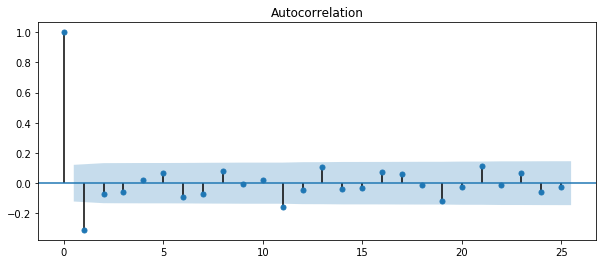

In [60]:
plot_acf(mh_ts.diff(1).dropna())
plt.show()

In [61]:
# it looks like from our ACF then, we have got rid of the trend through differenciating once 

In [62]:
mh_ts_stationary = mh_ts.diff(1).dropna()
kpss(mh_ts_stationary)   # null hypothesis: trend-stationary (no trend)

(0.03872032258284942,
 0.1,
 16,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

p-value of 0.1 > 0.05 - we accept the null hypothesis 

In [63]:
adfuller(mh_ts_stationary)   # null hypothesis: non-stationary (is a trend)

(-7.896442433728154,
 4.298280001628593e-12,
 14,
 245,
 {'1%': -3.4573260719088132,
  '5%': -2.873410402808354,
  '10%': -2.573095980841316},
 1633.6333313153978)

p-value of 0.0000000000043 < 0.05 - we reject the null hypothesis 

we can conclude that we have removed the trend, making the time series stationary after differeenciating once (d=1)

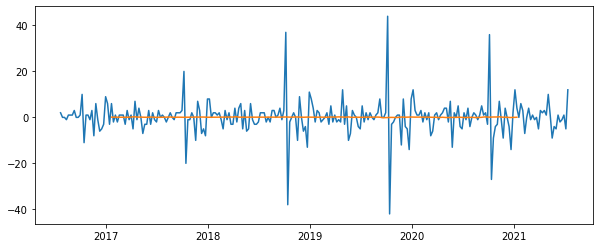

In [64]:
decomposition_stationary = seasonal_decompose(mh_ts_stationary)

plt.plot(mh_ts_stationary)
plt.plot(decomposition_stationary.trend)

d = 1

now we can start to get our p and q parameters. 

### Partial Autocorrelation function

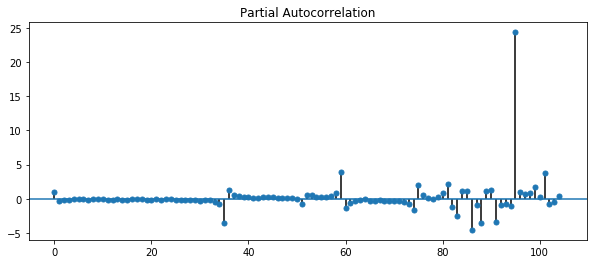

In [65]:
plot_pacf(mh_ts.diff(1).dropna(), lags = 104)
plt.show()

## We are going to repost our ACF here to figure out what our p,d and q values are 

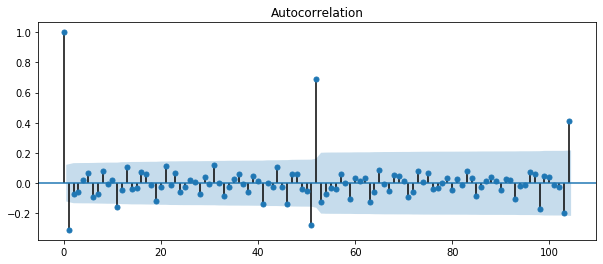

In [66]:
plot_acf(mh_ts.diff(1).dropna(), lags = 104)
plt.show()

ARIMA = ARIMA(p,d,q)

SARIMA = SARIMA(p,d,q)(P,D,Q)[Seasonality]

For the simple AR(p) terms, we first look at whether the ACF is positive or negative at lag 1. Here, ACF(1) is negative (about -0.3).This generally suggests you should not use any simple AR terms - if ACF(1) were positive, we would consider using simple AR terms. 
As we are not using simple AR terms our AR(p) = 0

The process for the seasonal AR terms(P) is similar, but we look at multiples of the seasonal period.
Here, the seasonal period is 52, so we look at ACF(52) and see if it is positive or negative. Here, ACF(52) is positive (about 0.6), suggesting we should use seasonal AR(P) terms.

Because we are going to use seasonal AR terms(P), we would find how many from the PACF plot, by looking at how many multiples of the seasonal period there are before it goes to near 0. Here, PACF(52) is non-zero, PACF(104) is similar (because there isn't a drastic change a safe bet is 1, so for our seasonal AR terms(P), we will use 1.

Here then, simple AR(p) = 0, seasonal AR(P) = 1

For the simple MA terms(q), look at ACF(1) (about -0.3 here). If it is negative, you might want to include some simple MA terms(q); if it is positive, you probably won't. Since it is negative here, we should use simple MA terms(q). We look at when the ACF drops to 0 to decide how many simple MA terms(q) to use. Here, ACF(1) is non-zero, but ACF(2) is close to 0 (inside the blue band), so we use 1 simple MA term(q). The number of simple MA terms(q) to use (if any) is the number of lags before the ACF drops to 0.

For seasonal MA terms(Q), we do the same, but looking at multiples of the seasonal period. ACF(52) is positive, suggesting we should not use seasonal MA terms(Q). ACF(104) isn't close to 0, suggesting we should not use seasonal MA term(Q).

Here then, simple MA(q) = 1, seasonal MA(Q) = 0

## SARIMA = SARIMA(p,d,q)(P,D,Q)[Seasonality]

### Therefore our SARIMA model = SARIMA(0,1,1)(1,1,0,52)

If there was no seasonal component 

model = ARIMA(0,1,1)

# 4. Building the Model 

In [67]:
mh_ts.head()

Week
2016-07-17    29
2016-07-24    31
2016-07-31    31
2016-08-07    31
2016-08-14    30
Name: mental health: (Worldwide), dtype: int64

In [68]:
mh_ts.tail()

Week
2021-06-13    50
2021-06-20    49
2021-06-27    50
2021-07-04    45
2021-07-11    57
Name: mental health: (Worldwide), dtype: int64

In [69]:
# train / test split

train = mh_ts[: '2019'].dropna()

test = mh_ts['2020' :].dropna()

#### Reminder of our model values = SARIMA(0,1,1)(1,1,0,52)

In [70]:
# seasonal ARIMA (SARIMA)

model = SARIMAX(train, order = (0,1,1), seasonal_order = (1,1,0,52), enforce_stationarity = False, enforce_inervitability = False)

# inervitability means giving values further away from the predicted value more weight, we don't want this 

In [71]:
results = model.fit()

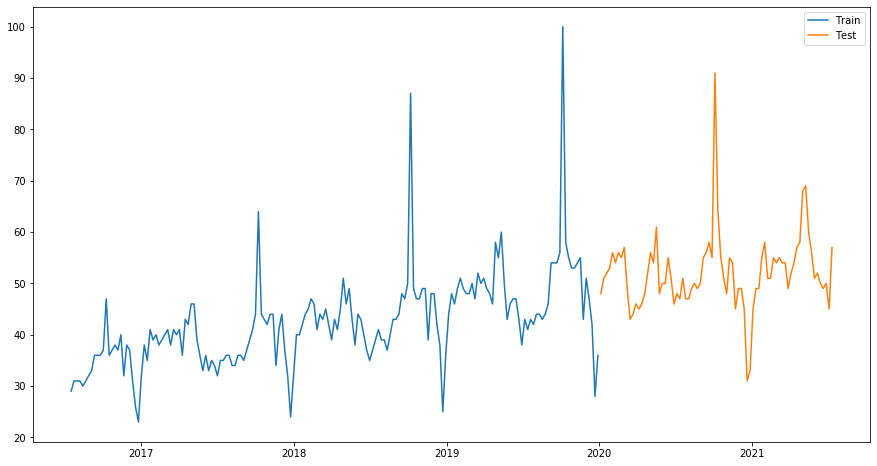

In [72]:
plt.figure(figsize =(15,8))
plt.plot(train, label = 'Train')  # from here, this is what we used to train our model 
plt.plot(test, label = 'Test')
plt.legend(loc = 'best')
plt.show()

In [73]:
pred = results.predict(start = '2020', end = '2021-07')

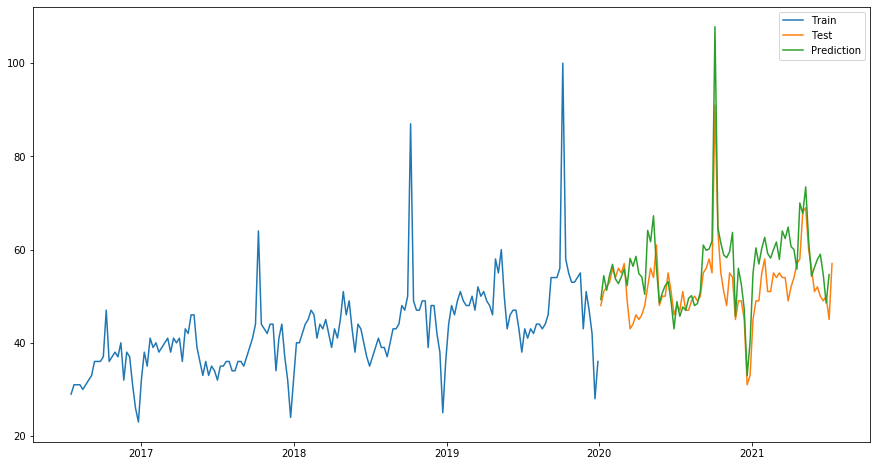

In [74]:
plt.figure(figsize =(15,8))
plt.plot(train, label = 'Train')
plt.plot(test, label = 'Test')
plt.plot(pred, label = 'Prediction')
plt.legend(loc = 'best')
plt.show()

In [75]:
pred = results.predict(start = '2016', end = '2021')

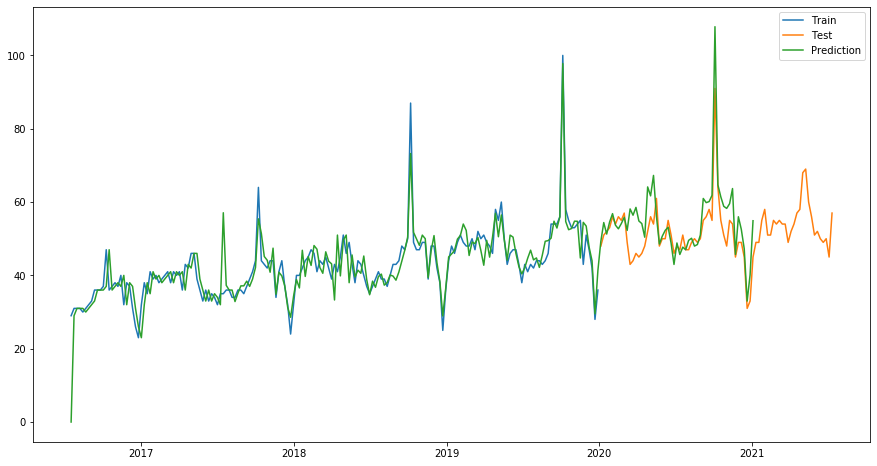

In [76]:
plt.figure(figsize =(15,8))
plt.plot(train, label = 'Train')
plt.plot(test, label = 'Test')
plt.plot(pred, label = 'Prediction')
plt.legend(loc = 'best')
plt.show()

In [77]:
forecast = results.predict(start = '2021-08', end = '2023')

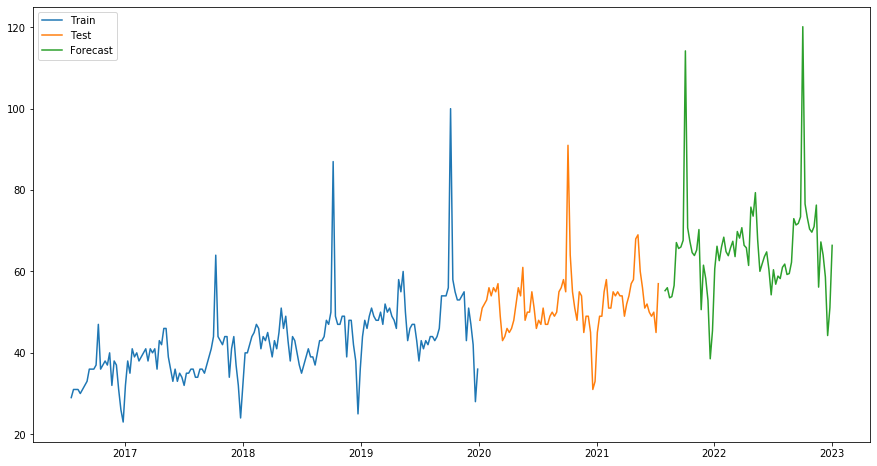

In [78]:
plt.figure(figsize =(15,8))
plt.plot(train, label = 'Train')
plt.plot(test, label = 'Test')
plt.plot(forecast, label = 'Forecast')
plt.legend(loc = 'best')
plt.show()

# 5. Evaluate the model

In [79]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:          mental health: (Worldwide)   No. Observations:                  181
Model:             SARIMAX(0, 1, 1)x(1, 1, [], 52)   Log Likelihood                -204.736
Date:                             Fri, 05 Aug 2022   AIC                            415.472
Time:                                     16:38:29   BIC                            422.464
Sample:                                 07-17-2016   HQIC                           418.267
                                      - 12-29-2019                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9931      0.281     -3.531      0.000      -1.544      -0.442
ar.S.L52       0.2846      0.072      3.944      0.000       0.143       0.426
sigma2        12.1721      3.460      3.518      0.000       5.390      18.954
===================================================================================
Ljung-Box (Q):                       32.55   Jarque-Bera (JB):                41.37
Prob(Q):                              0.79   Prob(JB):                         0.00
Heteroskedasticity (H):               1.43   Skew:                             0.70
Prob(H) (two-sided):                  0.37   Kurtosis:                         6.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

good models are obtained by minimising the AIC and BIC